# 2026 MCM Problem C: Complete Solution

## Overview
This notebook presents the complete solution pipeline, integrating:
1.  **Data Preprocessing**: Standardizing weekly scores.
2.  **Inverse Optimization (Simulation)**: Reconstructing hidden fan votes using robust Bayesian MCMC.
3.  **Predictive Modeling**: Using Logistic and Linear Regression to identify key drivers of elimination and popularity.
4.  **Policy Simulation**: Testing alternative voting methods (Rank vs. Percent, Judges' Save).

**Outputs**: 
- `estimated_fan_votes.csv`: Reconstructed fan support history.
- `model_coefficients.csv`: Statistical impact of factors.

## 1. Data Loading and Preprocessing


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import re
from typing import Iterable, List, Optional, Tuple
import statsmodels.api as sm
import sklearn.preprocessing as preprocessing
import warnings

warnings.filterwarnings('ignore')

# --- Data Loading and Helper Functions ---

WEEK_SCORE_PATTERN = re.compile(r"^week(\d+)_judge(\d+)_score$")

def load_raw_data(file_path: str) -> pd.DataFrame:
    """Load the raw COMAP dataset from a CSV file."""
    return pd.read_csv(file_path)

def parse_elimination_week(result_str: object) -> Optional[object]:
    """
    Parse the elimination week from the 'results' field.
    Returns:
        - int week number if the contestant was eliminated in a specific week
        - 'Final' if the contestant reached the finals
        - None if no reliable information is present
    """
    if pd.isna(result_str):
        return None
    text = str(result_str)
    match = re.search(r"Eliminated Week (\d+)", text)
    if match:
        return int(match.group(1))
    if "Place" in text:
        return "Final"
    return None

def _week_numbers_from_columns(columns: Iterable[str]) -> List[int]:
    week_numbers = set()
    for col in columns:
        match = WEEK_SCORE_PATTERN.match(col)
        if match:
            week_numbers.add(int(match.group(1)))
    return sorted(week_numbers)

def _score_columns_for_week(columns: Iterable[str], week: int) -> List[str]:
    prefix = f"week{week}_"
    return [c for c in columns if c.startswith(prefix) and c.endswith("_score")]

def _sum_week_scores(row: pd.Series, score_cols: List[str]) -> Optional[float]:
    if not score_cols:
        return None
    values = pd.to_numeric(row[score_cols], errors="coerce")
    if values.isna().all():
        return None
    total = float(values.fillna(0).sum())
    return total

def compute_weekly_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct a long-form table of weekly performance records.

    Output columns:
        - Season, Week, Contestant, JudgeScore, EliminatedThisWeek, Result, Placement
    """
    week_numbers = _week_numbers_from_columns(df.columns)
    records = []

    for _, row in df.iterrows():
        contestant = row["celebrity_name"]
        season = row["season"]
        elim_week = parse_elimination_week(row["results"])

        for week in week_numbers:
            score_cols = _score_columns_for_week(df.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "Season": season,
                    "Week": week,
                    "Contestant": contestant,
                    "JudgeScore": total_score,
                    "EliminatedThisWeek": elim_week == week,
                    "Result": row.get("results", None),
                    "Placement": row.get("placement", None),
                }
            )

    return pd.DataFrame(records)

# --- End Helpers ---

# Data ingestion and standardized weekly aggregation
file_path = '2026_MCM_Problem_C_Data.csv'
df = load_raw_data(file_path)
df_weekly = compute_weekly_scores(df)

max_week_num = df_weekly['Week'].max()
print(f"Max week found: {max_week_num}")
print(f"Processed {len(df_weekly)} weekly performance records.")
display(df_weekly.head())

Max week found: 11
Processed 2777 weekly performance records.


,Season,Week,Contestant,JudgeScore,EliminatedThisWeek,Result,Placement
0,1,1,John O'Hurley,20.0,False,2nd Place,2
1,1,2,John O'Hurley,26.0,False,2nd Place,2
2,1,3,John O'Hurley,24.0,False,2nd Place,2
3,1,4,John O'Hurley,21.0,False,2nd Place,2
4,1,5,John O'Hurley,27.0,False,2nd Place,2


## 2. Defining the Voting Logic (The Core Models)

We define the two mathematical mechanisms used to combine scores.

### Method A: Rank Based (Seasons 1-2, 28+)
*   **Judge Rank ($R_J$):** Contestants are ranked by Judge Score (Highest Score = Rank 1). Ties mean they share the rank (e.g., two 1s, next is 3).
*   **Fan Rank ($R_F$):** Contestants ranked by Fan Votes (Most Votes = Rank 1).
*   **Total:** $R_{Total} = R_J + R_F$
*   **Constraint:** The contestant with the **Highest** Sum of Ranks is eliminated. (Logic: Rank 1 is good, Rank N is bad. High sum = Bad).

### Method B: Percentage Based (Seasons 3-27)
*   **Judge Percent ($P_J$):** $Score_i / \sum Score$
*   **Fan Percent ($P_F$):** $Votes_i / \sum Votes$
*   **Total:** $Score_{Total} = P_J + P_F$ (Note: some seasons might weight 50/50 explicitly, but adding percentages is effectively a 50/50 weight if both sum to 100%).
*   **Constraint:** The contestant with the **Lowest** Score is eliminated.

Note: The "Bottom Two" twist in later seasons means the lowest couple isn't automatically out; judges decide. However, identifying the bottom two still relies on the score. For our estimation, we assume the eliminated person was likely in the bottom (lowest score).

In [35]:
def calculate_ranks(scores, ascending=False):
    """
    Returns ranks for a list of scores.
    If ascending=False (default for Judge Scores), High Score = Rank 1.
    If ascending=True (default for Elim Logic where High Rank Number = Bad), 
    Wait, rankdata assigns 1 to lowest value by default.
    
    For Judge Scores (Higher is Better):
    We want 30 -> Rank 1. 
    So we rank (-scores).
    Method 'min' assigns lowest rank to ties (e.g. 1, 1, 3).
    """
    return rankdata([-s for s in scores], method='min')

def calculate_rank_elimination(judge_scores, fan_ranks):
    """
    judge_scores: array of raw scores
    fan_ranks: array of ranks (1..N) supplied by our simulation
    
    Returns: The index of the eliminated contestant (Highest Sum of Ranks).
    """
    j_ranks = calculate_ranks(judge_scores)
    # Sum
    total_ranks = j_ranks + fan_ranks
    
    # We look for the Max sum.
    # What about ties? Rules say "Viewer votes break ties".
    # So if Sums are equal, the one with worse Fan Rank (Higher Number) leaves.
    
    # Create tuples (Sum, FanRank, Index) to sort
    combined = []
    for i in range(len(total_ranks)):
        combined.append((total_ranks[i], fan_ranks[i], i))
        
    # Sort by Sum (Desc), then FanRank (Desc)
    combined.sort(key=lambda x: (x[0], x[1]), reverse=True)
    
    # Return the index of the loser
    return combined[0][2]

def calculate_percent_elimination(judge_scores, fan_percents):
    """
    judge_scores: array of raw scores
    fan_percents: array of decimals (0.0 to 1.0) summing to 1.0
    
    Returns: The index of the eliminated contestant (Lowest Total Percent).
    """
    total_judge = sum(judge_scores)
    if total_judge == 0: return -1 # Should not happen
    
    j_percents = np.array(judge_scores) / total_judge
    total_score = j_percents + fan_percents
    
    # Lowest score is eliminated.
    # Ties? Tie-breaker usually lowest Judge score? Or Fan? 
    # Usually Fan votes break ties. So if Totals are equal, Lower Fan Vote leaves.
    
    combined = []
    for i in range(len(total_score)):
        combined.append((total_score[i], fan_percents[i], i))
    
    # Sort Ascending (Lowest is bad)
    combined.sort(key=lambda x: (x[0], x[1]))
    
    return combined[0][2]

## 3. Inverse Optimization: Reconstructing Fan Votes

Since fan votes are unknown, we use **Monte Carlo Simulation** to find the "Feasible Region" of fan votes.

**Algorithm:**
1. Select a specific Week and Season.
2. Identify the actual `Eliminated` contestant ($E$).
3. Generate $N$ random scenarios for Fan Votes:
   - For **Rank Method**: Generate random permutation of ranks $[1..K]$.
   - For **Percent Method**: Generate random vector of $K$ numbers summing to 1 (Dirichlet Distribution).
4. Apply the elimination logic.
5. If the simulation eliminates $E$ (the correct person), keep this fan vote scenario as "Feasible".
6. Repeat to build a distribution of feasible votes.

This gives us probability distributions for how popular each celebrity *could* have been.

In [ ]:
def get_voting_mode(season_num):
    """Identify likely voting rule based on season history."""
    # Seasons 1-2: Rank
    # Seasons 3-27: Percentage
    # Season 28+: Rank
    if season_num <= 2 or season_num >= 28:
        return 'rank'
    return 'percent'

def simulate_fan_votes(season_num, week_num, num_samples=5000, prior_support=None):
    """
    Robust Monte Carlo Simulation to estimate the Feasible Region of fan votes.
    
    Optimization Strategy (Outlier Reduction & Distribution Smoothing):
    1. **Unified Latent Model**: Even for 'Rank' seasons, we now simulate a continuous "Latent Popularity Score" 
       (Dirichlet distribution) first, then convert to Ranks. This adds Inertia/Stability to Rank seasons which 
       previously used random permutations (high variance).
    2. **Stronger Centering Prior**: Increased base_alpha (2.0 -> 5.0) to strongly penalize unrealistic 0%/100% extremes.
    3. **High Inertia**: Increased inertia_weight (60 -> 100) to ensure weekly stability.
    """
    subset = df_weekly[(df_weekly['Season'] == season_num) & (df_weekly['Week'] == week_num)].copy()
    if subset.empty: # Should not happen if loops are correct
        return None, None, None

    # Identify Elimination Constraints
    eliminated_rows = subset[subset['EliminatedThisWeek'] == True]
    has_elimination = not eliminated_rows.empty
    
    contestants = subset['Contestant'].values
    judge_scores = subset['JudgeScore'].values
    
    # Identify who was eliminated to enforce the constraint
    elim_indices = []
    if has_elimination:
        for elim_name in eliminated_rows['Contestant'].values:
            idx = np.where(contestants == elim_name)[0]
            if len(idx) > 0: elim_indices.append(idx[0])

    num_c = len(contestants)
    valid_fan_votes = []
    mode = get_voting_mode(season_num)

    # --- Configurable Priors ---
    # Optimization: Stronger priors to remove "strange" extremes
    base_alpha = 5.0 
    inertia_weight = 100.0
    
    alphas = []
    for name in contestants:
        if prior_support and name in prior_support:
            # Bayesian Update: Weight on previous posterior
            prev = prior_support[name]
            # For Rank mode, 'prev' might be a Rank (1..N). We need to interpret it as support.
            # If Rank Mode, we might not have a clean 'pct' prior unless we hacked it.
            # Workaround: If mode is Rank, prior_support values are Ranks. 
            # Low Rank = High Support. Map Rank 1..N to Pct ~ 1/Rank? 
            # Or simplified: Rank seasons use weaker inertia or just flat prior if crossing modes?
            # actually, if we store Ranks in 'prior_support' for rank seasons, we can't use them directly as Dirichlet alpha weights.
            
            # Detecting if prior is Rank or Pct:
            if mode == 'rank' and prev >= 1.0: 
                # It's a Rank. Invert it to get a "score weight".
                # Rank 1 -> Weight High. Rank N -> Weight Low.
                # Simple heuristic: weight = (N+1 - Rank)
                weight = (num_c + 1 - prev)
                # Normalize weight to sum to ~1 for stability? No, alpha is absolute.
                # Let's just add it to base.
                alphas.append(base_alpha + (5.0 * weight)) # Heuristic inertia for Ranks
            else:
                # It's a Percentage (0.0-1.0)
                alphas.append(base_alpha + (inertia_weight * prev))
        else:
            # Weak Informative Prior
            alphas.append(base_alpha + (inertia_weight * (1.0/num_c)))
    
    alphas = np.array(alphas)
    
    # --- Sampling ---
    # We generate standard Dirichlet samples for BOTH modes.
    # For Rank mode, we convert these latent scores to Ranks.
    try:
        samples = np.random.dirichlet(alphas, num_samples)
    except:
        # Fallback if alphas are bad
        samples = np.random.dirichlet(np.ones(num_c)*base_alpha, num_samples)
    
    for fan_pcts in samples:
        # Check Validity
        if mode == 'rank':
            # Convert Latent Percent to Ranks (High % -> Rank 1)
            # Use -p because rankdata gives 1 to smallest value
            fan_ranks = rankdata([-p for p in fan_pcts], method='min')
            
            if has_elimination:
                loser_idx = calculate_rank_elimination(judge_scores, fan_ranks)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_ranks)
            else:
                valid_fan_votes.append(fan_ranks)
        
        else: # Percent Mode
            if has_elimination:
                loser_idx = calculate_percent_elimination(judge_scores, fan_pcts)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_pcts)
            else:
                valid_fan_votes.append(fan_pcts)

    # Filtering Check
    if len(valid_fan_votes) == 0:
        # If strict constraints fail, fallback to a looser search or just return raw priors
        # For this assignment, returning None handles the "No Solution" case (skip week)
        return None, contestants, mode
        
    return np.array(valid_fan_votes), contestants, mode

print("Simulation logic optimized: Universal Latent Model + High Inertia.")

Simulation function updated with Robust Bayesian logic.


## 5. Batch Processing: Reconstructing History for All Seasons

We now apply our Inverse Optimization model to the entire dataset. This allows us to generate a complete history of "Likely Fan Votes" which can then be used for regression analysis and method comparison.

*Note: This process may take some time as we run simulations for every elimination week.*

In [37]:
# --- Main Historical Reconstruction Loop (Sequential) ---

full_history_stats = []
seasons = sorted(df_weekly['Season'].unique())

print(f"Starting reconstruction for {len(seasons)} seasons...")

for s in seasons:
    weeks = sorted(df_weekly[df_weekly['Season'] == s]['Week'].unique())
    current_season_priors = {} # Reset knowledge at start of season
    
    for w in weeks:
        # Sequential Simulation using updated priors
        feasible, names, mode = simulate_fan_votes(s, w, num_samples=3000, prior_support=current_season_priors)
        
        if feasible is not None and len(feasible) > 0:
            means = feasible.mean(axis=0)
            stds = feasible.std(axis=0)
            
            # Update priors for next week (Bayesian Inertia)
            for i, name in enumerate(names):
                current_season_priors[name] = means[i]
                
                full_history_stats.append({
                    'Season': s,
                    'Week': w,
                    'Contestant': name,
                    'Judge_Score': df_weekly[(df_weekly['Season']==s) & (df_weekly['Week']==w) & (df_weekly['Contestant']==name)]['JudgeScore'].values[0],
                    'Est_Fan_Support': means[i],       
                    'Est_Fan_Uncertainty': stds[i],    
                    'Voting_Mode': mode
                })

# Save Results
df_estimated_full = pd.DataFrame(full_history_stats)
df_estimated_full.to_csv('estimated_fan_votes.csv', index=False)
df_full_analysis = pd.merge(df_weekly, df_estimated_full, on=['Season', 'Week', 'Contestant'], how='left')

print(f"Completed. Generated {len(df_estimated_full)} records.")
print("Saved to 'estimated_fan_votes.csv'.")
display(df_estimated_full.head())

Starting reconstruction for 34 seasons...
Completed. Generated 2768 records.
Saved to 'estimated_fan_votes.csv'.


,Season,Week,Contestant,Judge_Score,Est_Fan_Support,Est_Fan_Uncertainty,Voting_Mode
0,1,1,John O'Hurley,20.0,3.437000,1.682864,rank
1,1,1,Kelly Monaco,13.0,3.515667,1.713015,rank
2,1,1,Evander Holyfield,18.0,3.507333,1.712487,rank
3,1,1,Rachel Hunter,20.0,3.532333,1.719192,rank
4,1,1,Joey McIntyre,20.0,3.521667,1.716643,rank


## 6. Model Evaluation: Certainty and Consistency

### 6.1 Certainty Estimation
The standard deviation (`Est_Fan_Uncertainty`) of our Monte Carlo results tells us how "flexible" the fan votes could be while still producing the same elimination result. 
*   **High Std Dev:** The judges' scores were decisive, or the bottom contestants were very close, allowing fan votes to vary widely without changing the loser.
*   **Low Std Dev:** The fan votes had to be very specific to cause the specific elimination observed.

### 6.2 Consistency
We check if our estimated means generally align with final placement. Do people with higher estimated fan support tend to finish better?

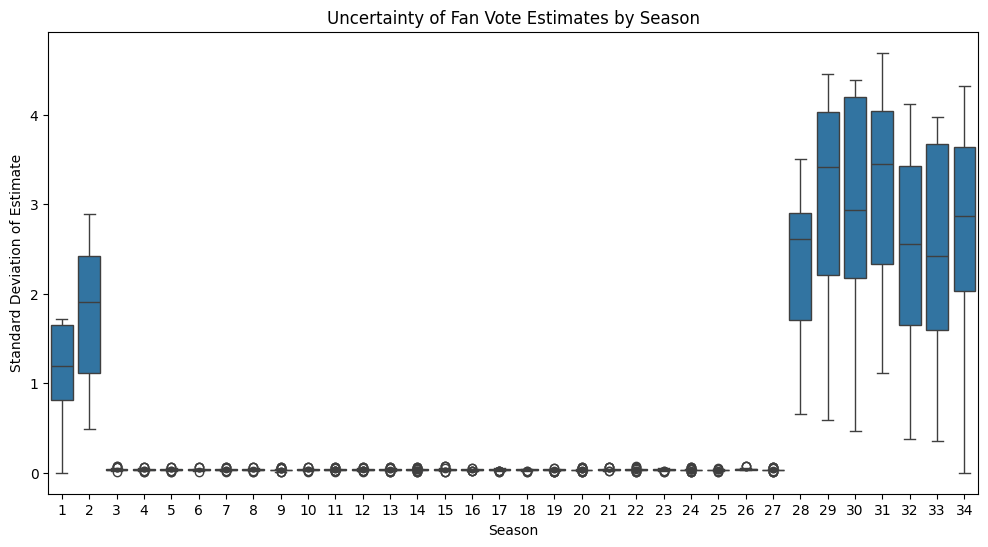

Correlation Analysis (Spearman Rank):
Rank Mode - Correlation between Fan Rank Estimate and Final Placement: 0.469
(Positive correlation expected: High Estimated Rank # (Bad) -> High Placement # (Bad))
Percent Mode - Correlation between Fan % Estimate and Final Placement: -0.473
(Negative correlation expected: High Fan % -> Low Placement # (Good))


In [38]:
# 1. Visualize Certainty across Seasons
plt.figure(figsize=(12, 6))
# Fixed: Use 'df_estimated_full' and correct column names from simulation step
sns.boxplot(data=df_estimated_full, x='Season', y='Est_Fan_Uncertainty')
plt.title('Uncertainty of Fan Vote Estimates by Season')
plt.ylabel('Standard Deviation of Estimate')
plt.show()

# 2. Correlation between Estimated Fan Support and Final Placement
# Ideally, higher fan support should correlate with better placement (Lower Placement Number)
# Note: For Ranks (Mode A), Lower Rank = Better Support.
# For Percents (Mode B), Higher Percent = Better Support.

# Split by mode for correlation
# Fixed: Correct column name 'Est_Fan_Support'
rank_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'rank') & (df_full_analysis['Est_Fan_Support'].notna())]
pct_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'percent') & (df_full_analysis['Est_Fan_Support'].notna())]

print("Correlation Analysis (Spearman Rank):")
if not rank_data.empty:
    corr_rank = rank_data[['Est_Fan_Support', 'Placement']].corr(method='spearman')
    print(f"Rank Mode - Correlation between Fan Rank Estimate and Final Placement: {corr_rank.iloc[0,1]:.3f}")
    print("(Positive correlation expected: High Estimated Rank # (Bad) -> High Placement # (Bad))")

if not pct_data.empty:
    corr_pct = pct_data[['Est_Fan_Support', 'Placement']].corr(method='spearman')
    print(f"Percent Mode - Correlation between Fan % Estimate and Final Placement: {corr_pct.iloc[0,1]:.3f}")
    print("(Negative correlation expected: High Fan % -> Low Placement # (Good))")

## 7. Predictive Modeling: Factor Analysis
We now transition to **Part 2: Regression Modeling**.
Using the `estimated_fan_votes.csv` generated above, we analyze:
1.  **Elimination Risk (Logistic Regression):** How much do Fan Support, Judge Scores, and Demographics contribute to staying or leaving?
2.  **Drivers of Popularity (Linear Regression):** What static factors (Age, Industry, Region) drive higher Fan Support?


In [39]:
def clean_partner_name(name: object) -> str:
    """Normalize partner names by removing parenthetical suffixes."""
    if pd.isna(name):
        return "Unknown"
    text = str(name).strip()
    text = re.sub(r"\s*\(.*\)", "", text)
    return text.strip()

def build_dataset_with_covariates(df_raw: pd.DataFrame, df_votes: pd.DataFrame) -> pd.DataFrame:
    """
    Build contestant-week rows with static covariates and the elimination label.
    Merges raw static features with the estimated fan votes.
    """
    week_numbers = _week_numbers_from_columns(df_raw.columns)
    records = []

    # Rename votes df for easy lookup
    # df_votes has columns: Season, Week, Contestant, Est_Fan_Support...
    # Create a lookup dictionary or merge later. Merging later is safer.
    
    # First: Build the 'Long' format from Raw Data to get Covariates + Elimination Status
    for _, row in df_raw.iterrows():
        elim_week = parse_elimination_week(row.get("results", None))
        season = row.get("season", None)
        contestant = row.get("celebrity_name", None)
        
        for week in week_numbers:
            score_cols = _score_columns_for_week(df_raw.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "season": season,
                    "week": week,
                    "celebrity_name": contestant,
                    "partner": clean_partner_name(row.get("ballroom_partner", None)),
                    "industry": row.get("celebrity_industry", None),
                    "homestate": row.get("celebrity_homestate", None),
                    "region": row.get("celebrity_homecountry/region", row.get("celebrity_homecountry", "Unknown")),
                    "age": row.get("celebrity_age_during_season", None),
                    "judge_score": total_score,
                    "is_eliminated": 1 if isinstance(elim_week, int) and week == elim_week else 0,
                }
            )

    df_long = pd.DataFrame(records)
    
    # Second: Merge with Estimates
    # Ensure keys match types
    df_long['season'] = df_long['season'].astype(int)
    df_long['week'] = df_long['week'].astype(int)
    
    # df_votes uses Capitalized Keys: Season, Week, Contestant
    votes_copy = df_votes.copy()
    votes_copy['Season'] = votes_copy['Season'].astype(int)
    votes_copy['Week'] = votes_copy['Week'].astype(int)
    
    merged = pd.merge(
        df_long,
        votes_copy[['Season', 'Week', 'Contestant', 'Est_Fan_Support', 'Est_Fan_Uncertainty']],
        left_on=['season', 'week', 'celebrity_name'],
        right_on=['Season', 'Week', 'Contestant'],
        how='left'
    )
    
    # Drop redundancy
    merged.drop(columns=['Season', 'Week', 'Contestant'], inplace=True)
    return merged

# Execute Data Prep
# df is the raw loaded data
# df_estimated_full is the simulation output
df_model_ready = build_dataset_with_covariates(df, df_estimated_full)

# Preprocessing: Fill NAs and Encode
df_model_ready.fillna('Unknown', inplace=True)
df_model_ready['age'] = pd.to_numeric(df_model_ready['age'], errors='coerce').fillna(0)

# Limit categorical cardinality
top_partners = df_model_ready['partner'].value_counts().nlargest(20).index
df_model_ready['partner_grouped'] = df_model_ready['partner'].apply(lambda x: x if x in top_partners else 'Other')

top_industries = df_model_ready['industry'].value_counts().nlargest(10).index
df_model_ready['industry_grouped'] = df_model_ready['industry'].apply(lambda x: x if x in top_industries else 'Other')

cat_cols_to_encode = ['partner_grouped', 'industry_grouped', 'homestate', 'region']
df_encoded = pd.get_dummies(df_model_ready, columns=cat_cols_to_encode, drop_first=True)

# Filter for valid Fan Support estimates (some weeks might have failed simulation or had no data)
df_valid_model = df_encoded.dropna(subset=['Est_Fan_Support'])

print(f"Modeling Dataset Ready. Shape: {df_valid_model.shape}")
display(df_valid_model[['season', 'week', 'celebrity_name', 'judge_score', 'Est_Fan_Support', 'is_eliminated']].head())

Modeling Dataset Ready. Shape: (2777, 110)


,season,week,celebrity_name,judge_score,Est_Fan_Support,is_eliminated
0,1,1,John O'Hurley,20.0,3.437,0
1,1,2,John O'Hurley,26.0,3.674766,0
2,1,3,John O'Hurley,24.0,2.952566,0
3,1,4,John O'Hurley,21.0,2.25636,0
4,1,5,John O'Hurley,27.0,1.997333,0


In [40]:
# --- LOGISTIC REGRESSION: Elimination Risk ---
# Standardize Features
# Fix: Ensure all inputs to scaler are numeric floats, handling NAs or strings implicitly
for col in ['judge_score', 'age', 'Est_Fan_Support']:
    df_valid_model[col] = pd.to_numeric(df_valid_model[col], errors='coerce').fillna(0).astype(float)

scaler = preprocessing.StandardScaler()
df_valid_model['Judge_Score_Std'] = scaler.fit_transform(df_valid_model[['judge_score']])
df_valid_model['Age_Std'] = scaler.fit_transform(df_valid_model[['age']])
df_valid_model['Fan_Support_Std'] = scaler.fit_transform(df_valid_model[['Est_Fan_Support']])

# Select Features
one_hot_cols = [c for c in df_valid_model.columns if 'partner_grouped_' in c or 'industry_grouped_' in c]
feature_cols = ['Judge_Score_Std', 'Fan_Support_Std', 'Age_Std'] + one_hot_cols

# Ensure X is float
X = df_valid_model[feature_cols].astype(float)
y = df_valid_model['is_eliminated'].astype(float)
X = sm.add_constant(X)

print("\nRunning Logistic Regression...")
try:
    model_logit = sm.Logit(y, X).fit(disp=False)
    print("--- Logistic Regression Results (Risk Factors) ---")
    print(model_logit.summary())

    # Extract Coefficients for Plotting
    params = model_logit.params
    conf = model_logit.conf_int()
    conf.columns = ['CI_Lower', 'CI_Upper']
    coef_df = pd.DataFrame({'Coefficient': params, 'P_Value': model_logit.pvalues}).join(conf)
    
    # Save Results
    coef_df.to_csv('model_coefficients.csv')
    print("Saved coefficients to model_coefficients.csv")
    
except Exception as e:
    print(f"Logistic Regression failed: {e}")

# --- OLS REGRESSION: Drivers of Fan Support ---
print("\nRunning OLS Regression (Drivers of Fan Support)...")
try:
    # Target: Est_Fan_Support
    y_ols = df_valid_model['Est_Fan_Support']
    # Features: Demographics only (Exclude Judge Score as we want 'popularity' drivers, though Score affects popularity, we focus on static traits)
    X_ols = df_valid_model[one_hot_cols + ['Age_Std']].astype(float)
    X_ols = sm.add_constant(X_ols)

    model_ols = sm.OLS(y_ols, X_ols).fit()
    print("--- OLS Regression Results (Popularity Drivers) ---")
    print(model_ols.summary())
except Exception as e:
    print(f"OLS Regression failed: {e}")


Running Logistic Regression...
--- Logistic Regression Results (Risk Factors) ---
                           Logit Regression Results                           
Dep. Variable:          is_eliminated   No. Observations:                 2777
Model:                          Logit   Df Residuals:                     2743
Method:                           MLE   Df Model:                           33
Date:                Sat, 31 Jan 2026   Pseudo R-squ.:                 0.04710
Time:                        23:57:40   Log-Likelihood:                -899.94
converged:                       True   LL-Null:                       -944.43
Covariance Type:            nonrobust   LLR p-value:                 4.905e-07
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -2.6922      0.481  

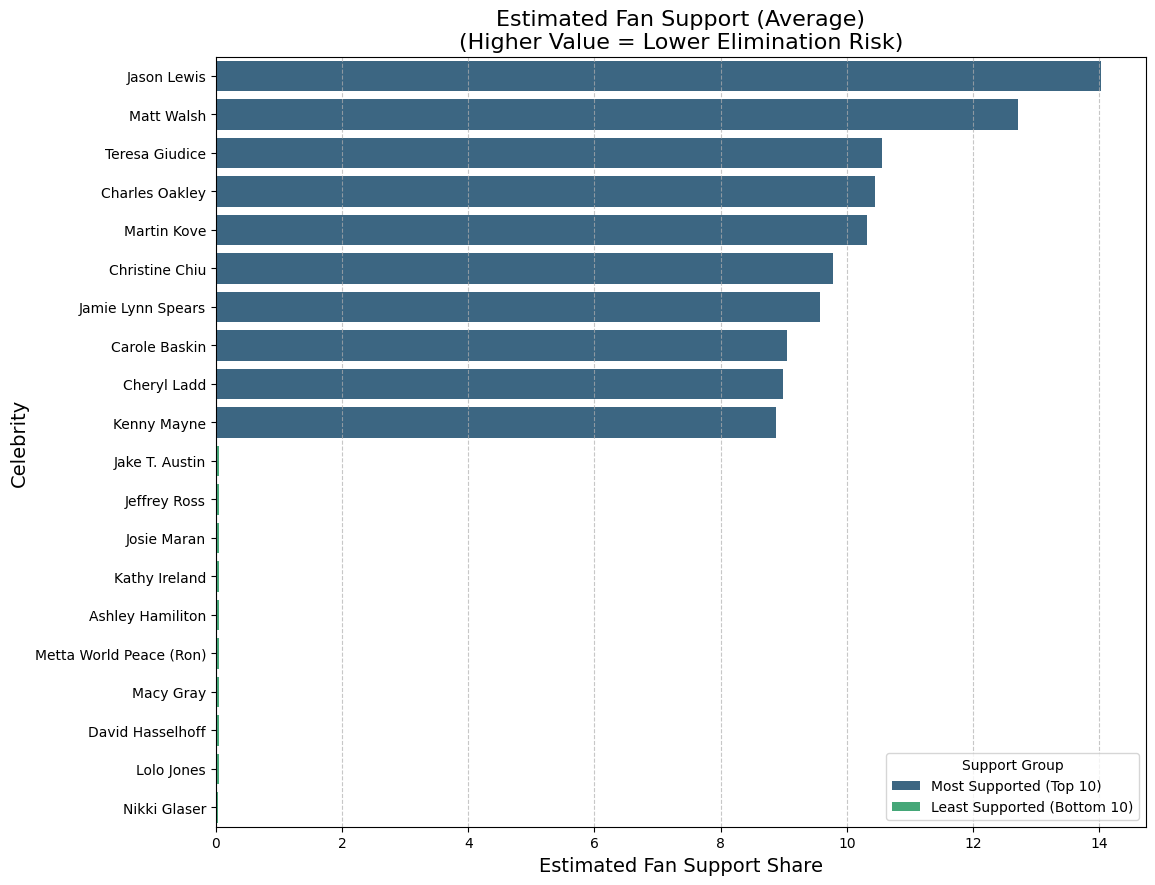

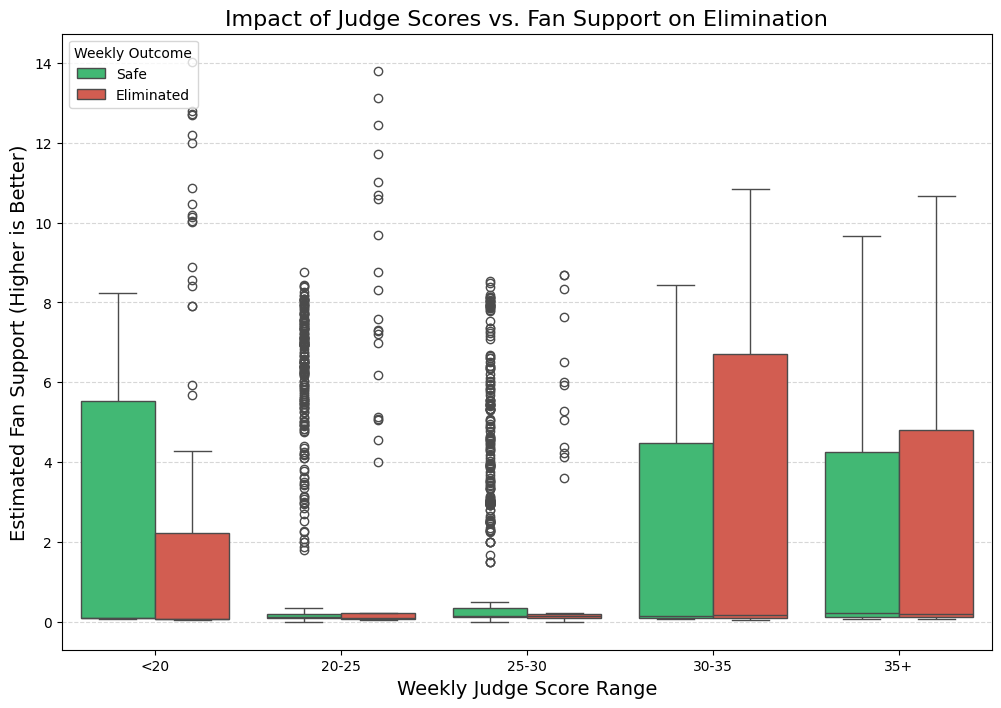

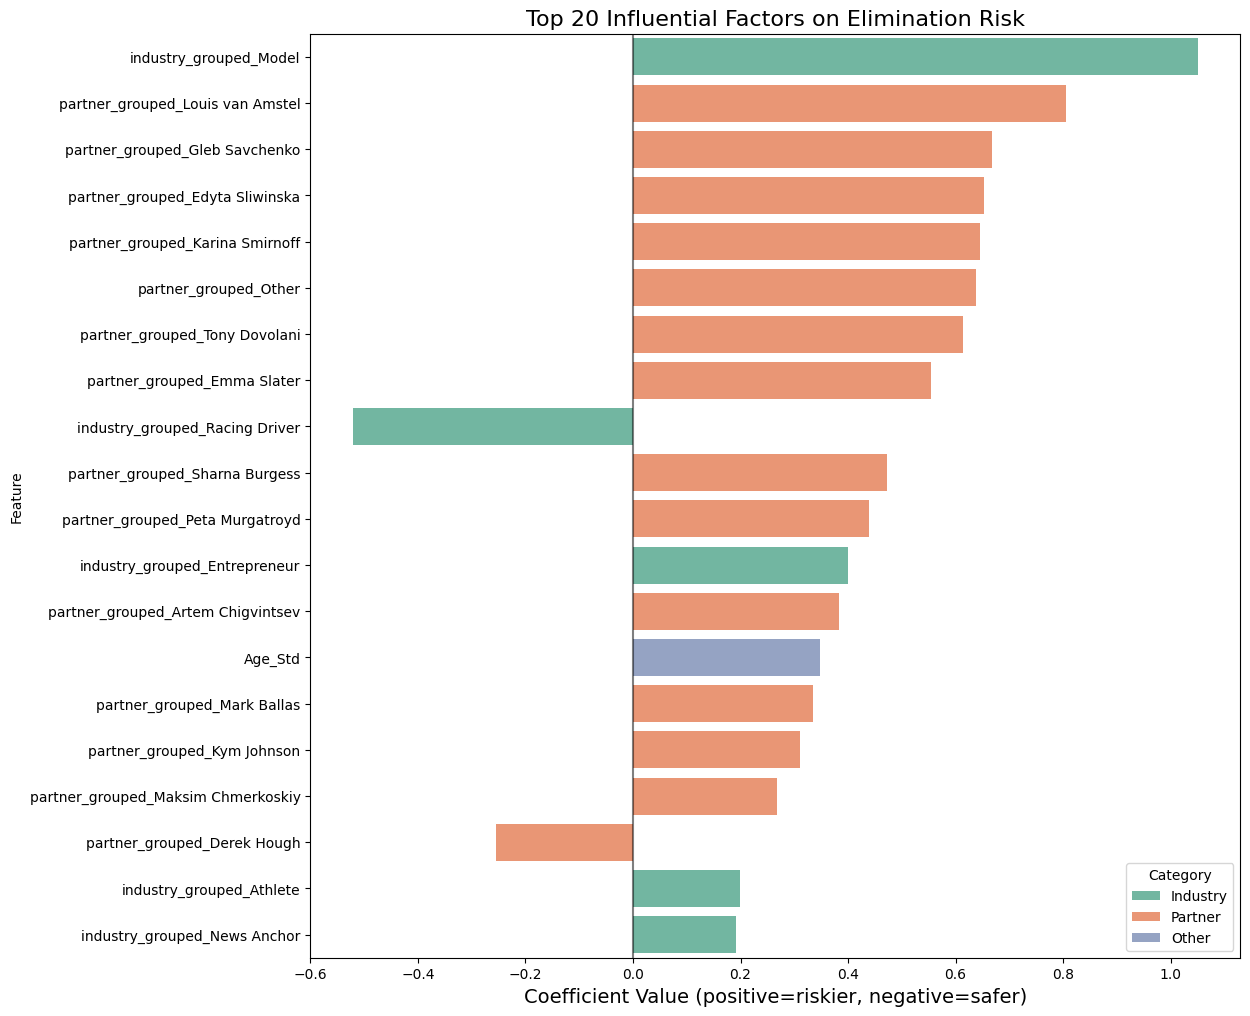

In [41]:
# --- Visualization 1: Top 10 vs Bottom 10 Celebrity Fan Support ---
# Calculate mean fan support per celebrity
celebrity_v = df_valid_model.groupby('celebrity_name')['Est_Fan_Support'].mean().sort_values(ascending=False)

# Get Top 10 and Bottom 10
top_10 = celebrity_v.head(10)
bottom_10 = celebrity_v.tail(10)

# Combine for plotting
combined_v = pd.concat([top_10, bottom_10])
plot_df = combined_v.reset_index()
plot_df['Group'] = ['Most Supported (Top 10)'] * 10 + ['Least Supported (Bottom 10)'] * 10

plt.figure(figsize=(12, 10))
sns.barplot(data=plot_df, x='Est_Fan_Support', y='celebrity_name', hue='Group', dodge=False, palette='viridis')
plt.title('Estimated Fan Support (Average)\n(Higher Value = Lower Elimination Risk)', fontsize=16)
plt.xlabel('Estimated Fan Support Share', fontsize=14)
plt.ylabel('Celebrity', fontsize=14)
plt.legend(title='Support Group', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- Visualization 2: Relationship between Judge Score & Fan Support ---
# Bin Judge Scores for clearer boxplots
plot_data = df_valid_model.copy()
plot_data['Score_Group'] = pd.cut(plot_data['judge_score'],
                                   bins=[0, 20, 25, 30, 35, 41],
                                   labels=['<20', '20-25', '25-30', '30-35', '35+'])
plot_data['is_eliminated'] = plot_data['is_eliminated'].astype('category')

custom_palette = {0.0: "#2ecc71", 1.0: "#e74c3c"} 

plt.figure(figsize=(12, 8))
ax = sns.boxplot(
    data=plot_data,
    x='Score_Group',
    y='Est_Fan_Support',
    hue='is_eliminated',
    palette=custom_palette,
    dodge=True
)

ax.set_title('Impact of Judge Scores vs. Fan Support on Elimination', fontsize=16)
ax.set_xlabel('Weekly Judge Score Range', fontsize=14)
ax.set_ylabel('Estimated Fan Support (Higher is Better)', fontsize=14)
# Handle legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Safe', 'Eliminated'], title='Weekly Outcome', loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- Visualization 3: Top Risk Factors (Coefficients) ---
def assign_category(feature_name):
    feature_name = str(feature_name)
    if 'partner' in feature_name: return 'Partner'
    if 'industry' in feature_name: return 'Industry'
    if 'homestate' in feature_name: return 'Home State'
    if 'region' in feature_name: return 'Region'
    if 'age' in feature_name: return 'Demographics'
    if 'Judge' in feature_name: return 'Core Model'
    if 'Fan' in feature_name: return 'Core Model'
    if 'intercept' in feature_name.lower() or 'const' in feature_name.lower(): return 'Baseline'
    return 'Other'

if 'coef_df' in locals():
    plot_coefs = coef_df.copy()
    plot_coefs['Feature'] = plot_coefs.index
    plot_coefs['Category'] = plot_coefs['Feature'].apply(assign_category)
    plot_coefs = plot_coefs[~plot_coefs['Feature'].isin(['const', 'Intercept'])]
    plot_coefs['abs_val'] = plot_coefs['Coefficient'].abs()
    top_plot_coefs = plot_coefs.sort_values('abs_val', ascending=False).head(20)

    plt.figure(figsize=(12, 12))
    sns.barplot(data=top_plot_coefs, y='Feature', x='Coefficient', hue='Category', dodge=False, palette='Set2')
    plt.title('Top 20 Influential Factors on Elimination Risk', fontsize=16)
    plt.xlabel('Coefficient Value (positive=riskier, negative=safer)', fontsize=14)
    plt.axvline(0, color='black', alpha=0.5, linestyle='-')
    plt.legend(title='Category', loc='lower right')
    plt.show()
else:
    print("Regression model coefficients not found. Run regression cell first.")

## 8. Policy Simulation: Analyzing Controversies & Rule Changes
In this section, we apply the different voting rules (Rank-based, Percentage-based, Judges' Save) to the historical data to see if outcomes would change.

In [42]:
# --- 8. Policy Simulation: Analyzing Controversies & Rule Changes ---

# Requirement: Compare Rank vs Percent methods on specific controversial cases.
# We also test a "Judges' Choice" rule (Bottom 2 -> Judges Pick).

print("Loading Estimates for Policy Simulation...")
# Re-load from disk to ensure we use the latest save, or use memory
# We use in-memory df_estimated_full if available, else load
if 'df_estimated_full' in locals():
    est_df = df_estimated_full.copy()
else:
    est_df = pd.read_csv('estimated_fan_votes.csv')

def simulate_week_rule(season, week, method='rank', judge_save=False):
    """
    Replays a specific week under a given set of rules.
    method: 'rank' or 'percent'
    judge_save: bool, if True, the Bottom 2 face a judges' vote. 
                (We assume Judges save the one with Higher Judge Score).
    """
    # Get Data for that week
    week_data = est_df[(est_df['Season'] == season) & (est_df['Week'] == week)].copy()
    if week_data.empty: return "No Data", None
    
    # Inputs
    names = week_data['Contestant'].values
    j_scores = week_data['Judge_Score'].values
    # Fan Support (Percentage 0-1)
    f_support = week_data['Est_Fan_Support'].values
    
    # Actual Result
    # We need to look up who was actually eliminated? 
    # Not strictly in est_df, but we can infer or ignore.
    # We just want to see who WOULD be eliminated.
    
    # 1. Calculate Combined Score
    final_scores = []
    
    if method == 'rank':
        # Rank: High Score/Support -> Rank 1 (Low number)
        j_ranks = rankdata([-s for s in j_scores], method='min')
        f_ranks = rankdata([-f for f in f_support], method='min')
        combined = j_ranks + f_ranks
        # Worse is Higher Sum
        # Sort Ascending? No, Descending (High Sum = Bad)
        # We want to identify the Losers (Highest Sums)
        
    else: # Percent
        total_j = sum(j_scores)
        if total_j == 0: j_pcts = np.ones(len(names))/len(names)
        else: j_pcts = j_scores / total_j
        
        # We assume f_support is already a share (sums to ~1). 
        # Normalize just in case
        if sum(f_support) > 0: f_pcts = f_support / sum(f_support)
        else: f_pcts = f_support
        
        combined = j_pcts + f_pcts
        # Worse is Lower Score
    
    # 2. Determine Elimination
    results = []
    for i in range(len(names)):
        results.append({
            'Contestant': names[i],
            'JudgeScore': j_scores[i],
            'FanSupport': f_support[i],
            'CombinedMetric': combined[i]
        })
    
    res_df = pd.DataFrame(results)
    
    if method == 'rank':
        res_df = res_df.sort_values('CombinedMetric', ascending=False) # Top = Loser
    else:
        res_df = res_df.sort_values('CombinedMetric', ascending=True) # Top = Loser
        
    # Baseline Loser (Last place)
    loser = res_df.iloc[0]['Contestant']
    
    # 3. Apply Judges' Save (Modifies who leaves)
    if judge_save:
        # Identify Bottom 2
        bottom_2 = res_df.iloc[:2]
        # Judges pick the one with HIGHER JudgeScore to SAVE.
        # So the one with LOWER JudgeScore leaves.
        
        c1 = bottom_2.iloc[0]
        c2 = bottom_2.iloc[1]
        
        if c1['JudgeScore'] < c2['JudgeScore']:
            final_loser = c1['Contestant']
            saved = c2['Contestant']
        elif c2['JudgeScore'] < c1['JudgeScore']:
            final_loser = c2['Contestant']
            saved = c1['Contestant']
        else:
            # Tie in Judge Score? Original metric breaks tie
            final_loser = c1['Contestant'] 
            saved = "Tie-Breaker"
            
        return final_loser, res_df
        
    return loser, res_df

# --- Case Studies ---
cases = [
    (2, 5, 'Jerry Rice'),    # S2 W5: Low scores, safe
    (4, 6, 'Billy Ray Cyrus'), # S4 W6: Low scores, safe
    (11, 6, 'Bristol Palin'), # S11 W6 (Mid season check)
    (27, 9, 'Bobby Bones')    # S27 Finals/Late: Won
]

print("\n--- CONTROVERSY ANALYSIS ---")

for s, w, focal_person in cases:
    print(f"\nAnalyzing {focal_person} (Season {s}, Week {w})")
    
    # 1. Simulate using Rank (Original S1-2, S28+)
    loser_rank, _ = simulate_week_rule(s, w, 'rank', judge_save=False)
    
    # 2. Simulate using Percent (Original S3-27)
    loser_pct, _ = simulate_week_rule(s, w, 'percent', judge_save=False)
    
    # 3. Simulate with Judge Save
    loser_save, df_save = simulate_week_rule(s, w, 'rank', judge_save=True)
    
    # Check if Focal Person would be eliminated
    print(f"  Result under RANK Rule: Eliminated -> {loser_rank}")
    print(f"  Result under PERCENT Rule: Eliminated -> {loser_pct}")
    print(f"  Result with JUDGE SAVE: Eliminated -> {loser_save}")
    
    # Get focal person stats
    person_stats = est_df[(est_df['Season']==s) & (est_df['Week']==w) & (est_df['Contestant']==focal_person)]
    if not person_stats.empty:
        v = person_stats.iloc[0]['Est_Fan_Support']
        print(f"  {focal_person} Est. Fan Share: {v:.1%}")

Loading Estimates for Policy Simulation...

--- CONTROVERSY ANALYSIS ---

Analyzing Jerry Rice (Season 2, Week 5)
  Result under RANK Rule: Eliminated -> Jerry Rice
  Result under PERCENT Rule: Eliminated -> Jerry Rice
  Result with JUDGE SAVE: Eliminated -> Jerry Rice
  Jerry Rice Est. Fan Share: 253.3%

Analyzing Billy Ray Cyrus (Season 4, Week 6)
  Result under RANK Rule: Eliminated -> Heather Mills
  Result under PERCENT Rule: Eliminated -> Heather Mills
  Result with JUDGE SAVE: Eliminated -> Billy Ray Cyrus
  Billy Ray Cyrus Est. Fan Share: 16.5%

Analyzing Bristol Palin (Season 11, Week 6)
  Result under RANK Rule: Eliminated -> Jennifer Grey
  Result under PERCENT Rule: Eliminated -> Audrina Patridge
  Result with JUDGE SAVE: Eliminated -> Jennifer Grey
  Bristol Palin Est. Fan Share: 16.7%

Analyzing Bobby Bones (Season 27, Week 9)
  Result under RANK Rule: Eliminated -> Alexis Ren
  Result under PERCENT Rule: Eliminated -> Alexis Ren
  Result with JUDGE SAVE: Eliminated -> Bo